Goal: interpret the model in a white-box fashion, looking inside the model at the learned filters and analyzing saliency maps for what positions and nucleotides matter most towards functional characteristics.

In [1]:
# import statements 

import os

import platform
import random
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras
%matplotlib inline

# some visualization imports
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import logomaker as lm

# various imports for the keras model
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import keras as keras
#from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv1D, Concatenate
from keras.optimizers import SGD
from keras.regularizers import l2

# evaluate performance w/ on and off regression separately 
from scipy.stats import pearsonr, spearmanr 

# imports for the grid search and kfold CV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# data one-hot encoding imports
from pysster.One_Hot_Encoder import One_Hot_Encoder
from sklearn import preprocessing
from keras.utils import to_categorical

import matplotlib
import matplotlib.font_manager as fm
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

Using TensorFlow backend.


# Part 1: Load in data

In [40]:
data_dir ='../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
data_df.head(3)

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA   

                         ...                              stem2  \
0                        ...                          CCATTTTTT   
1                        ...                          GTTTTCCAT   
2                        ...                          CAATAGTAG   

                       linker post_linker  on_value off_value  onoff_value  \
0  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA       NaN  0.333333          NaN   
1  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA       NaN       NaN          NaN   
2  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA  0.068295  0.000000     0.068295   

   on_qc  off_qc  onoff_qc                                    switch_sequence  
0    NaN     NaN       NaN  AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...  
1    NaN     NaN       NaN  AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...  
2    2.0     1.1       1.1  AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...  

[3 rows x 22 columns]

In [41]:
qc_cutoff=1.1
data_df = data_df[data_df['on_qc'] >= qc_cutoff].reset_index()
data_df = data_df[data_df['off_qc'] >= qc_cutoff].reset_index()
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Number of remaining sequences: ', len(data_df))

Number of remaining sequences:  91534


In [42]:
# clean up matrix
data_df = data_df[['switch_sequence', 'on_value', 'off_value', 'onoff_value']]

# Part 2: Get sets of 100 bad and 100 good

In [43]:
best = data_df[data_df['onoff_value'] > data_df['onoff_value'].quantile(.95)]
worst = data_df[data_df['onoff_value'] < data_df['onoff_value'].quantile(.05)]

best.head()

switch_sequence  on_value  off_value  \
4   AAAAAAACCAACACAGCTCCAGGAACATTAAACAGAGGAGATAATG...  1.000000   0.089756   
17  AAAAAAATTATAATATTCGTATTAGCATCAAACAGAGGAGATGATG...  0.919890   0.020877   
26  AAAAAACTCTTTGGTCATGTCTTTCTCTTTAACAGAGGAGAAAAGA...  1.000000   0.128028   
38  AAAAAATAAAACTAGAGATTGAAACGTGTTAACAGAGGAGAAACAC...  0.848531   0.069694   
50  AAAAAATTCAAAGATGTTCTGTTTATCTTTAACAGAGGAGAAAAGA...  1.000000   0.196838   

    onoff_value  
4      0.910244  
17     0.899013  
26     0.871972  
38     0.778837  
50     0.803162

In [45]:
num_seqs_to_test = 100
best_sample = best.sample(n=num_seqs_to_test)
worst_sample = worst.sample(n=num_seqs_to_test)

best_sample.head()

switch_sequence  on_value  off_value  \
25947  CACCCTAGCACAAACAGCTGAATTTGTTTAAACAGAGGAGATAAAC...  0.871810   0.085668   
52387  GCTCTGAATCAGAACGATCTGAAGAAATAGAACAGAGGAGACTATT...  0.950077   0.109098   
2942   AACTAAATTGTAGTGTATATATAGACCATAAACAGAGGAGATATGG...  1.000000   0.179671   
47877  GAGTCTGGAAGATAGTAAGGTAAGACTCTAAACAGAGGAGATAGAG...  1.000000   0.144642   
37422  CTAATCAATCCTTTTGGGATCTCCATGTTTAACAGAGGAGAAAACA...  1.000000   0.092425   

       onoff_value  
25947     0.786142  
52387     0.840979  
2942      0.820329  
47877     0.855358  
37422     0.907575

# Part 3. Transform Data. One-hot encode sequences and extact target on and off values.

In [46]:
alph_letters = sorted('ATCG')
alph = list(alph_letters)

# one-hot encode
one = One_Hot_Encoder(alph_letters)
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    return one_hot_seq

# now convert the data into one_hot_encoding 
input_col_name = 'switch_sequence'#'switch'
X_best = np.stack([_get_one_hot_encoding(s) for s in best_sample[input_col_name]]).astype(np.float32)
X_worst = np.stack([_get_one_hot_encoding(s) for s in worst_sample[input_col_name]]).astype(np.float32)

# reformat for CNN if needeed
print('input shape: ', X_best.shape)
alph_len = len(alph)
seq_len = len(data_df[input_col_name][0])
X_best = X_best.reshape(X_best.shape[0], seq_len, alph_len).astype('float32')
X_worst = X_worst.reshape(X_worst.shape[0], seq_len, alph_len).astype('float32')
print('modified shape: ', X_best.shape)

input shape:  (100, 59, 4)
modified shape:  (100, 59, 4)


# Part 4. Load in final model. 

In [47]:
from tensorflow.keras.models import load_model

output_dir = '../fig2/trained_model/'
final_model_path = output_dir + 'final_trained_model.h5'
final_weights_path = output_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

In [48]:
# visually check architecture is the same
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 59, 4)        0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 59, 10)       210         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 59, 5)        155         conv_0[0][0]                     
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 295)          0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_4 

# Part 5. Generate saliency maps from GOOD toeholds. 

In [49]:
# look at saliency map for positive vs. negative classes
# modified code from keras-vis package github page 
# https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb

from keras.models import load_model
final_model_path = output_dir + 'final_trained_model.h5'
final_weights_path = output_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

# layer idx = what layer to maximize/minimize (i.e. output node)
# seed_input = the one-hot encoded sequence whose path thru the model we are tracing 
# filter_indices = what layer are we computing saliency w/ r.t. (i.e. input layer)

def viz_saliency_bar(model, seed_input, layer_idx=-2, filter_indices=0, grad_modifier=None, plotting = True):
    # maximize on prediction or minimize off prediction  
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=filter_indices, seed_input=seed_input,
                              grad_modifier=grad_modifier)
    # diff colors in plot represent the saliency of specific positions 
    if plotting:
        plt.rcParams["figure.figsize"] = 5,1

        x = list(range(0,seq_len))
        y = grads
        fig, ax = plt.subplots(ncols=1, sharex=True)

        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        ax.imshow(y[np.newaxis,:], cmap="jet", aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        plt.tight_layout()
        plt.show()
    return grads

# Part 5a. Maximize ON values.

In [50]:
grads = [] 
rand_indices = range(0, num_seqs_to_test)

for idx in rand_indices:
    grad = viz_saliency_bar(model, X_best[idx],plotting=False, layer_idx=-2, grad_modifier=None, filter_indices=0)
    grads.append(grad)
    
# look at average saliency based on original nucleotide
grads_over_letters_on = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_on = {c: np.zeros(seq_len) for c in alph}

def ohot_to_seq(onehot_seq): 
    # return from one hot seq back to original toehold
    # get original letter based on index of the 1 
    seq = ''.join([alph[np.where(onehot_seq[idx] == 1)[0][0]] for idx in range(len(onehot_seq))])
    return seq 

for sample_idx,idx in enumerate(rand_indices): 
    onehot_toehold = X_best[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads[sample_idx][position]
        grads_over_letters_on[nt][position] += grad_at_pos
        counts_per_positon_on[nt][position] += 1 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


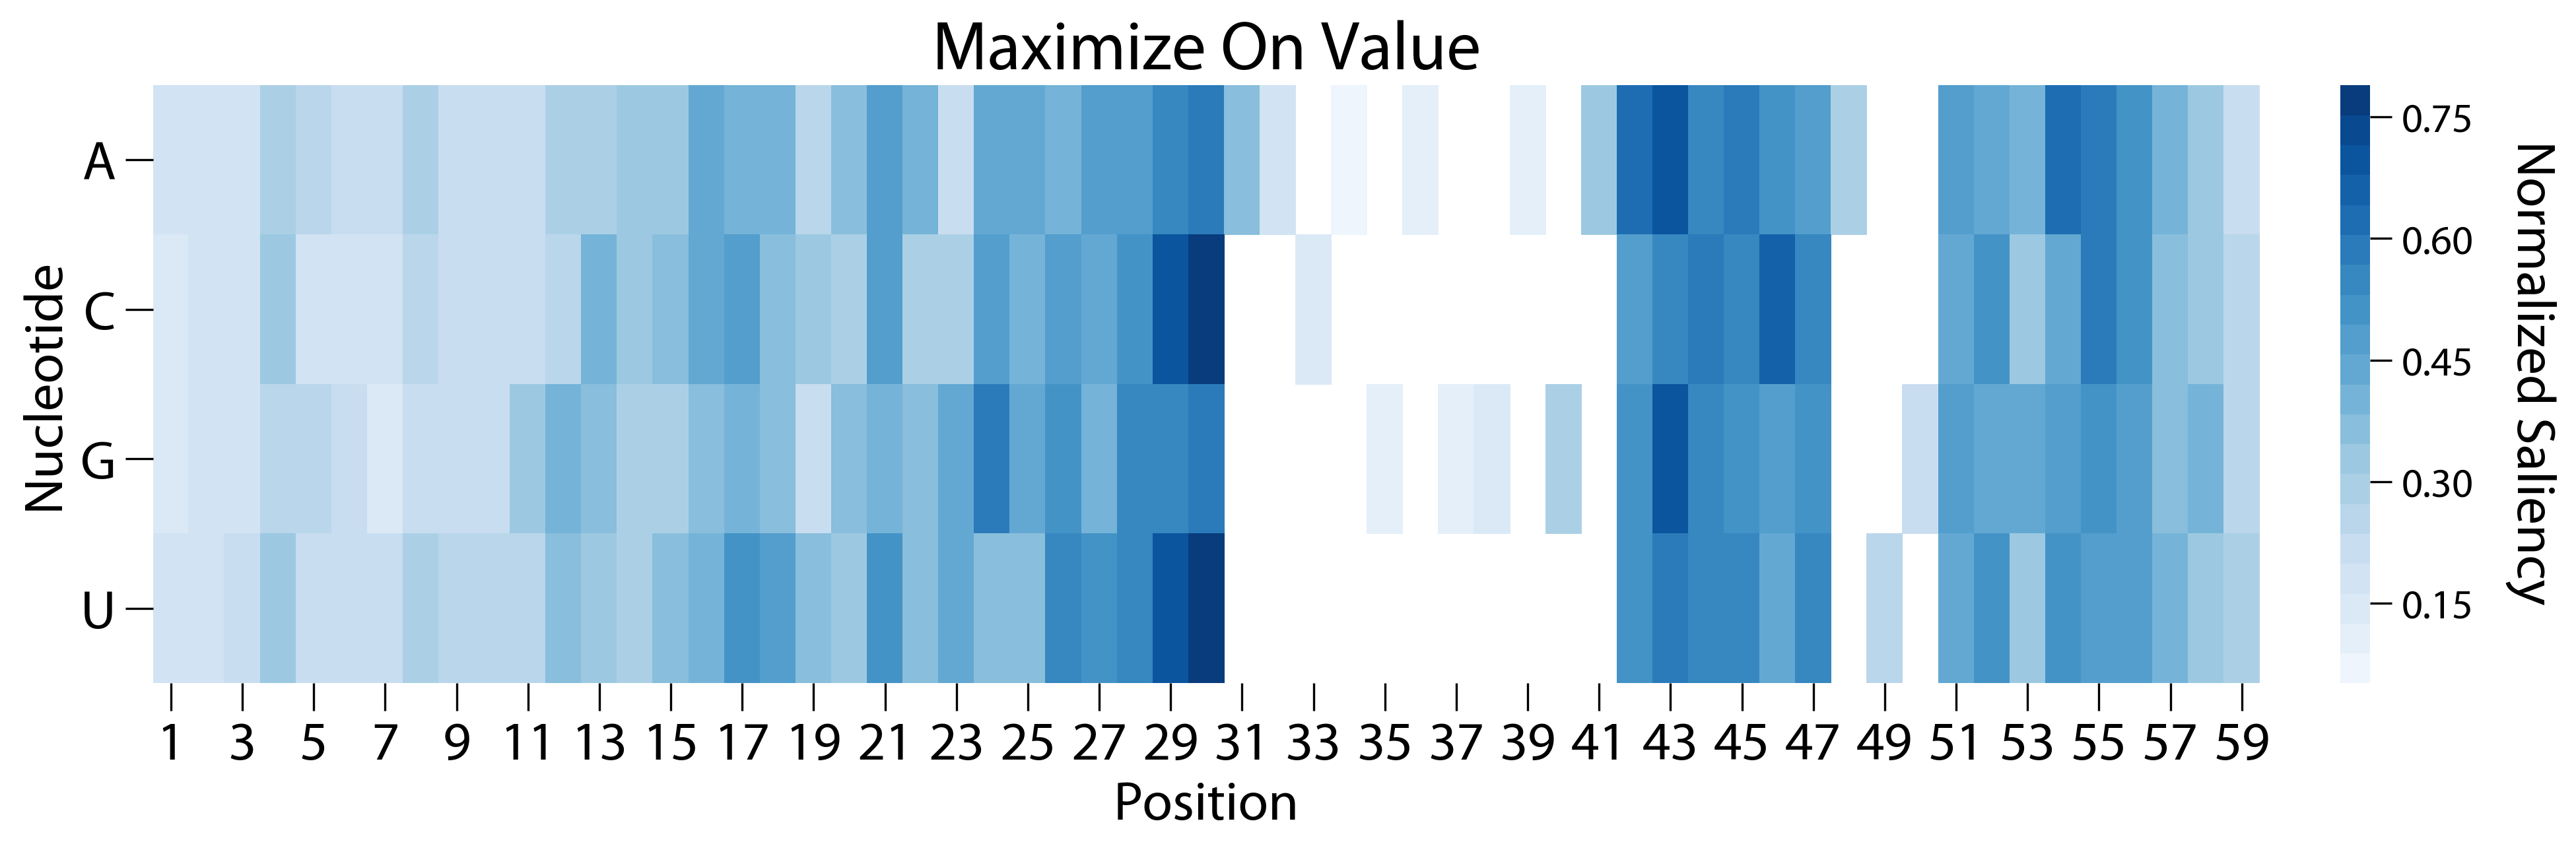

In [52]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)


g = sns.heatmap([grads_over_letters_on[letter]/counts_per_positon_on[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, **axis_font, fontsize = 20, rotation = 0)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Maximize On Value', **axis_font, fontsize = 25)
out_dir = '../../illustrator_files/supp/'
#plt.savefig(out_dir + 's4a_max_on_good_saliency.svg', format = 'svg')

# Part 5b. Minimize OFF values.

In [53]:
grads_off = [] 
# randomly draw samples (w/o replacement)
for idx in rand_indices:
    grad = viz_saliency_bar(model, X_best[idx],plotting=False,layer_idx=-1, grad_modifier='negate', filter_indices=0)
    grads_off.append(grad)

# look at average saliency based on original nucleotide
grads_over_letters_off = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_off = {c: np.zeros(seq_len) for c in alph}

for sample_idx,idx in enumerate(rand_indices): 
    onehot_toehold = X_best[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads_off[sample_idx][position]
        grads_over_letters_off[nt][position] += grad_at_pos
        counts_per_positon_off[nt][position] += 1 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


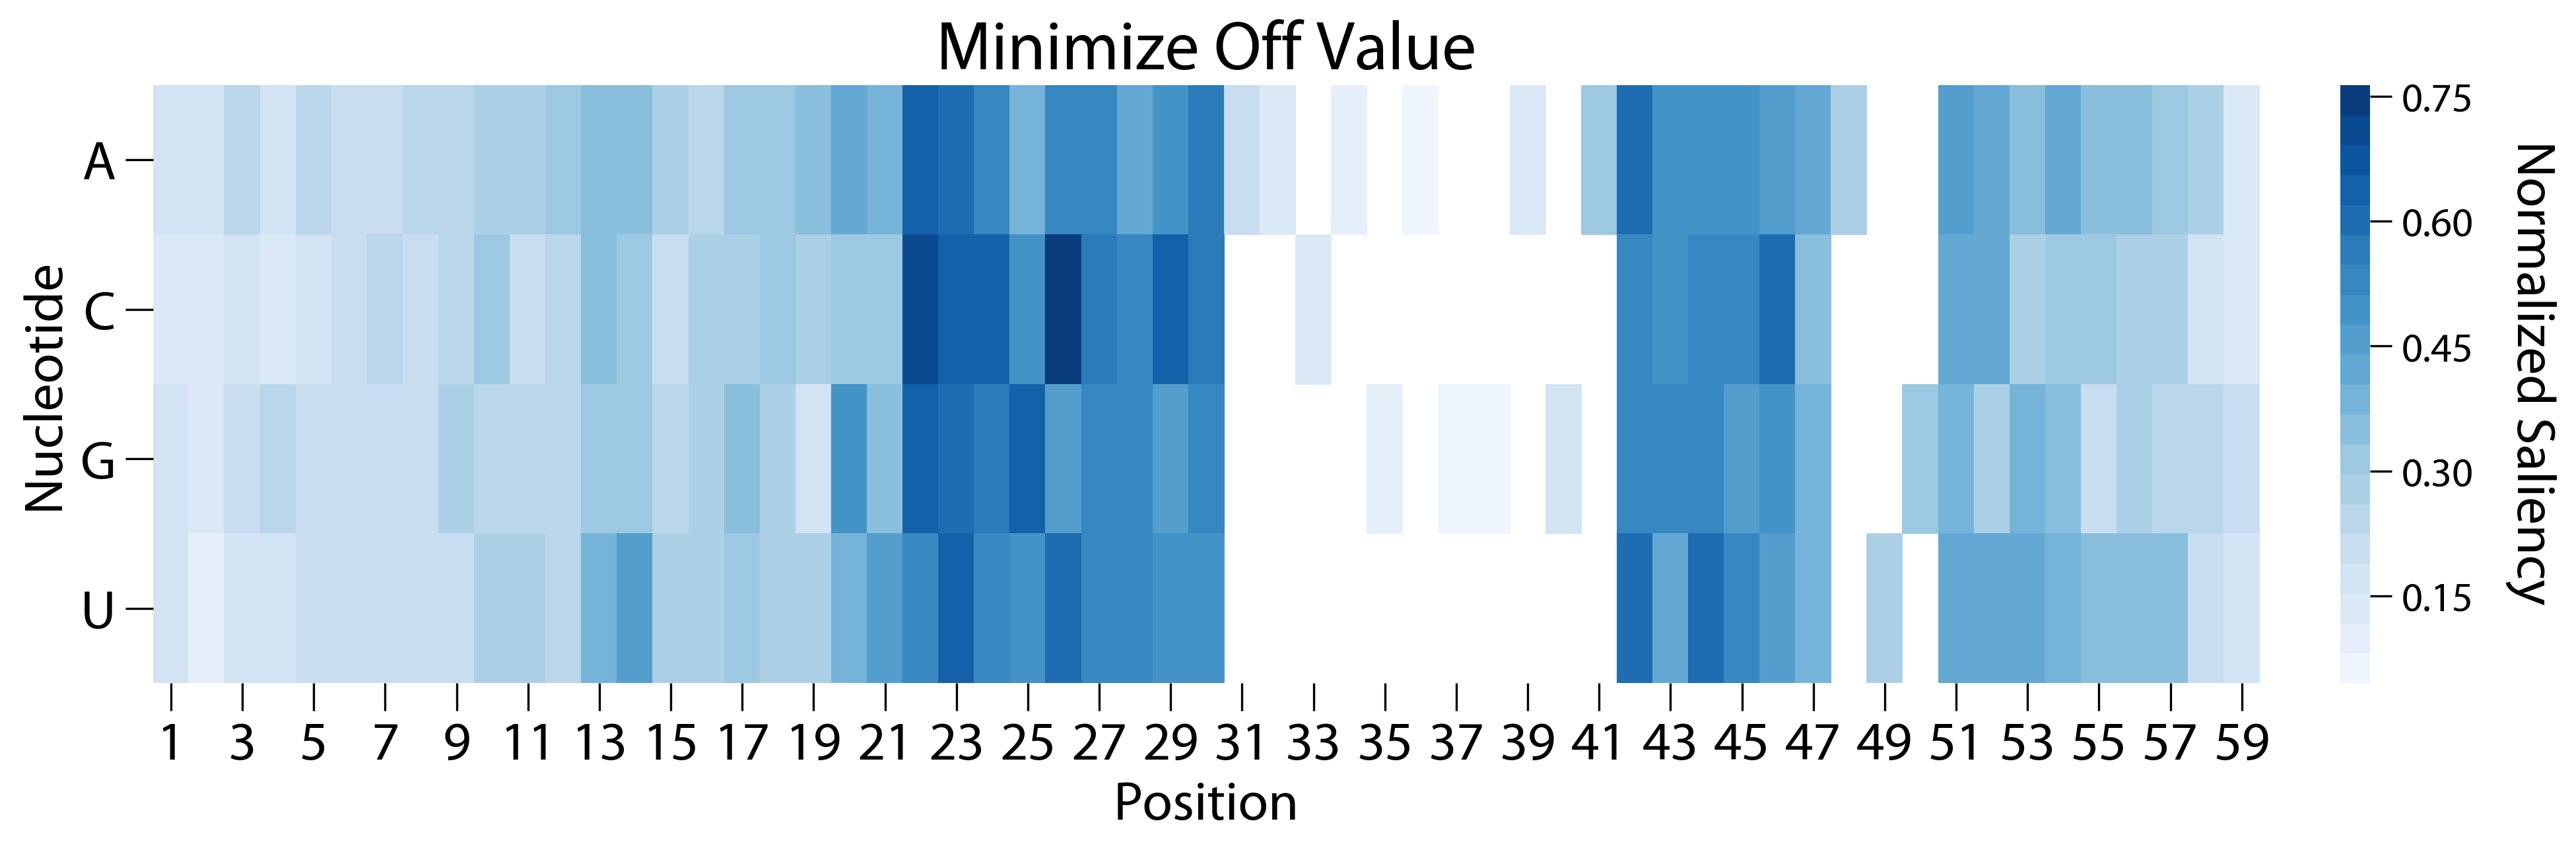

In [55]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)

g = sns.heatmap([grads_over_letters_off[letter]/counts_per_positon_off[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, rotation = 0, **axis_font, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Minimize Off Value', **axis_font, fontsize = 25)
#out_dir = '../../illustrator_files/supp/'
#plt.savefig(out_dir + 's4b_min_off_good_saliency.svg', format = 'svg')

# Part 6. Generate saliency maps from BAD toeholds. 

# Part 6a. Maximize ON values.

In [56]:
grads = [] 

for idx in rand_indices:
    grad = viz_saliency_bar(model, X_worst[idx],plotting=False, layer_idx=-2, grad_modifier=None, filter_indices=0)
    grads.append(grad)
    
    # look at average saliency based on original nucleotide
grads_over_letters_on = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_on = {c: np.zeros(seq_len) for c in alph}

for sample_idx,idx in enumerate(rand_indices): 
    onehot_toehold = X_worst[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads[sample_idx][position]
        grads_over_letters_on[nt][position] += grad_at_pos
        counts_per_positon_on[nt][position] += 1 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


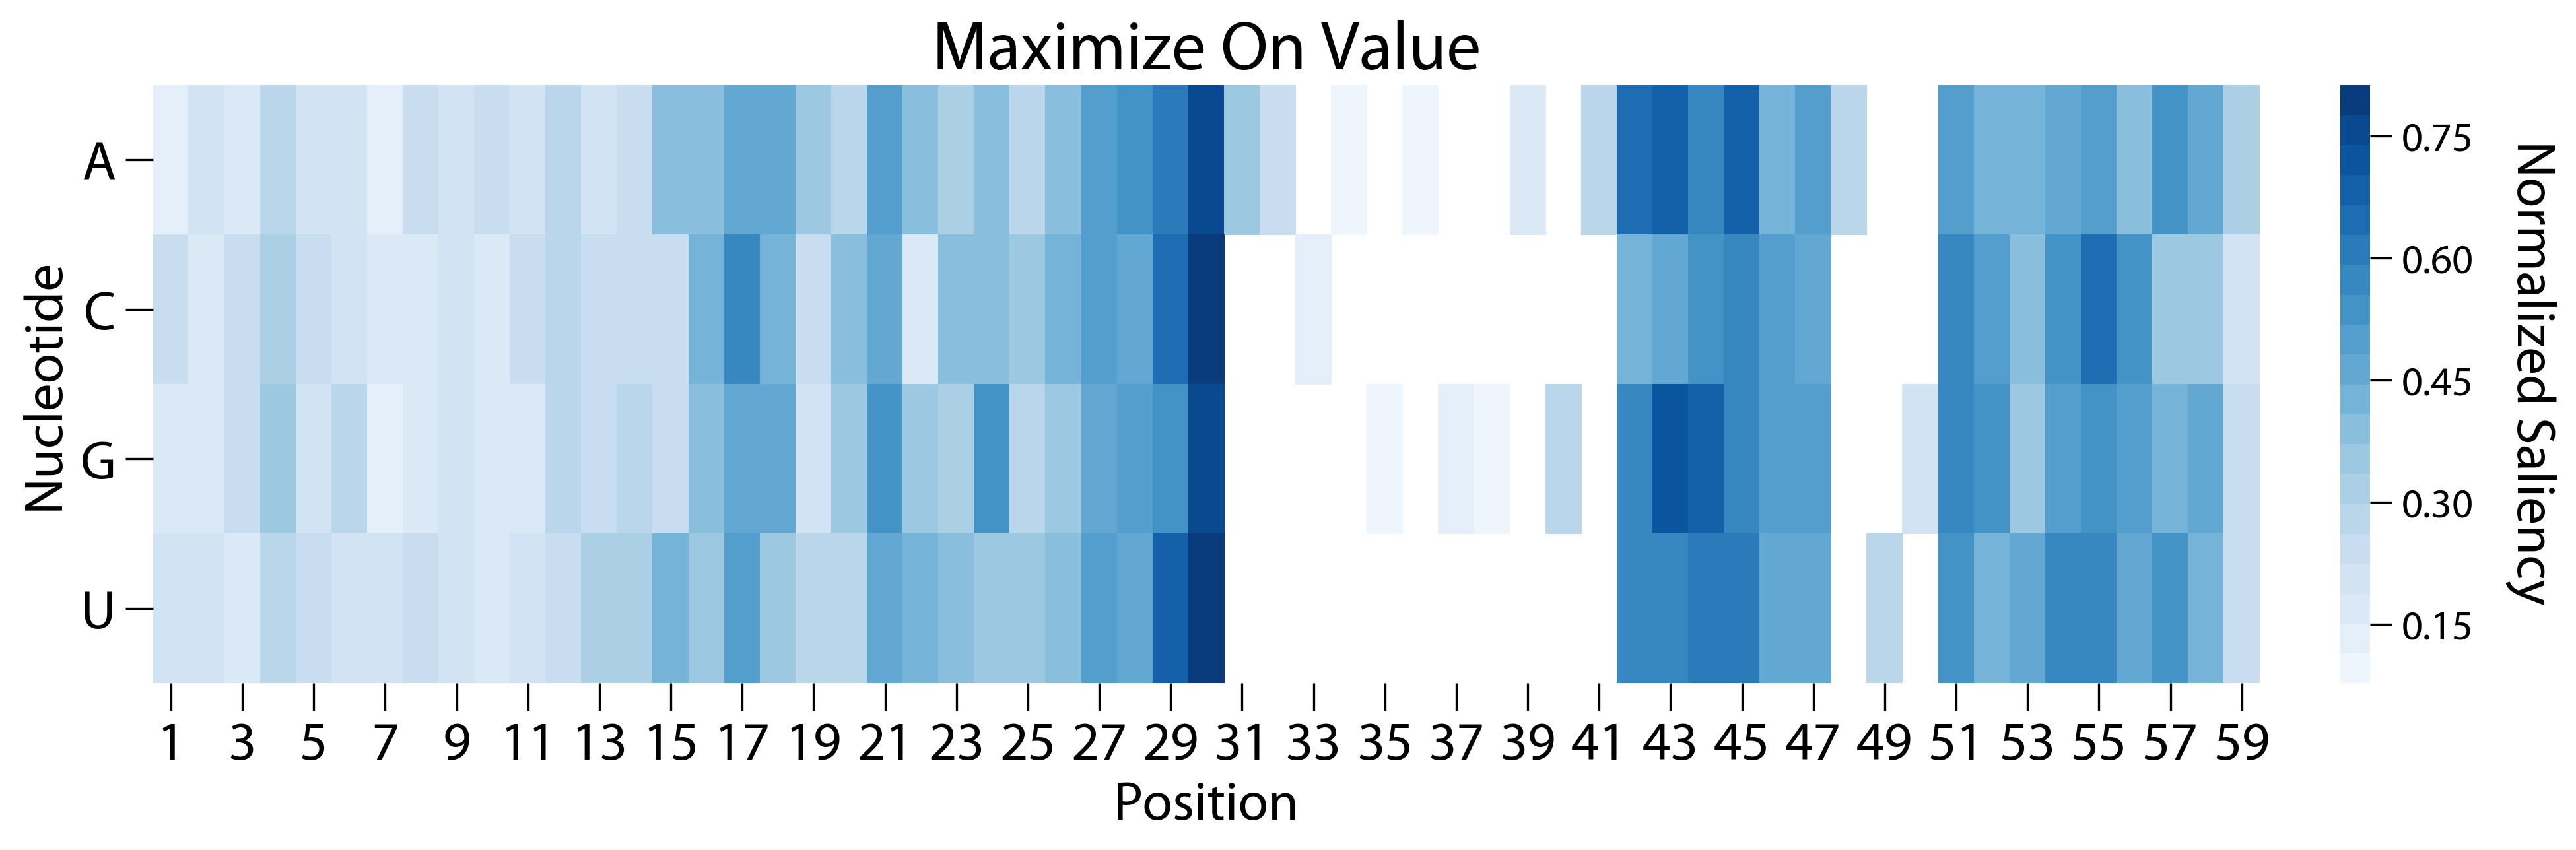

In [57]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)


g = sns.heatmap([grads_over_letters_on[letter]/counts_per_positon_on[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, **axis_font, fontsize = 20, rotation = 0)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Maximize On Value', **axis_font, fontsize = 25)
#out_dir = '../../illustrator_files/supp/'
#plt.savefig(out_dir + 's4c_max_on_bad_saliency.svg', format = 'svg')

# Part 6b. Minimize OFF values.

In [58]:
grads_off = [] 
# randomly draw samples (w/o replacement)
for idx in rand_indices:
    grad = viz_saliency_bar(model, X_worst[idx],plotting=False,layer_idx=-1, grad_modifier='negate', filter_indices=0)
    grads_off.append(grad)
    
# look at average saliency based on original nucleotide
grads_over_letters_off = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_off = {c: np.zeros(seq_len) for c in alph}

for sample_idx,idx in enumerate(rand_indices): 
    onehot_toehold = X_worst[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads_off[sample_idx][position]
        grads_over_letters_off[nt][position] += grad_at_pos
        counts_per_positon_off[nt][position] += 1      

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


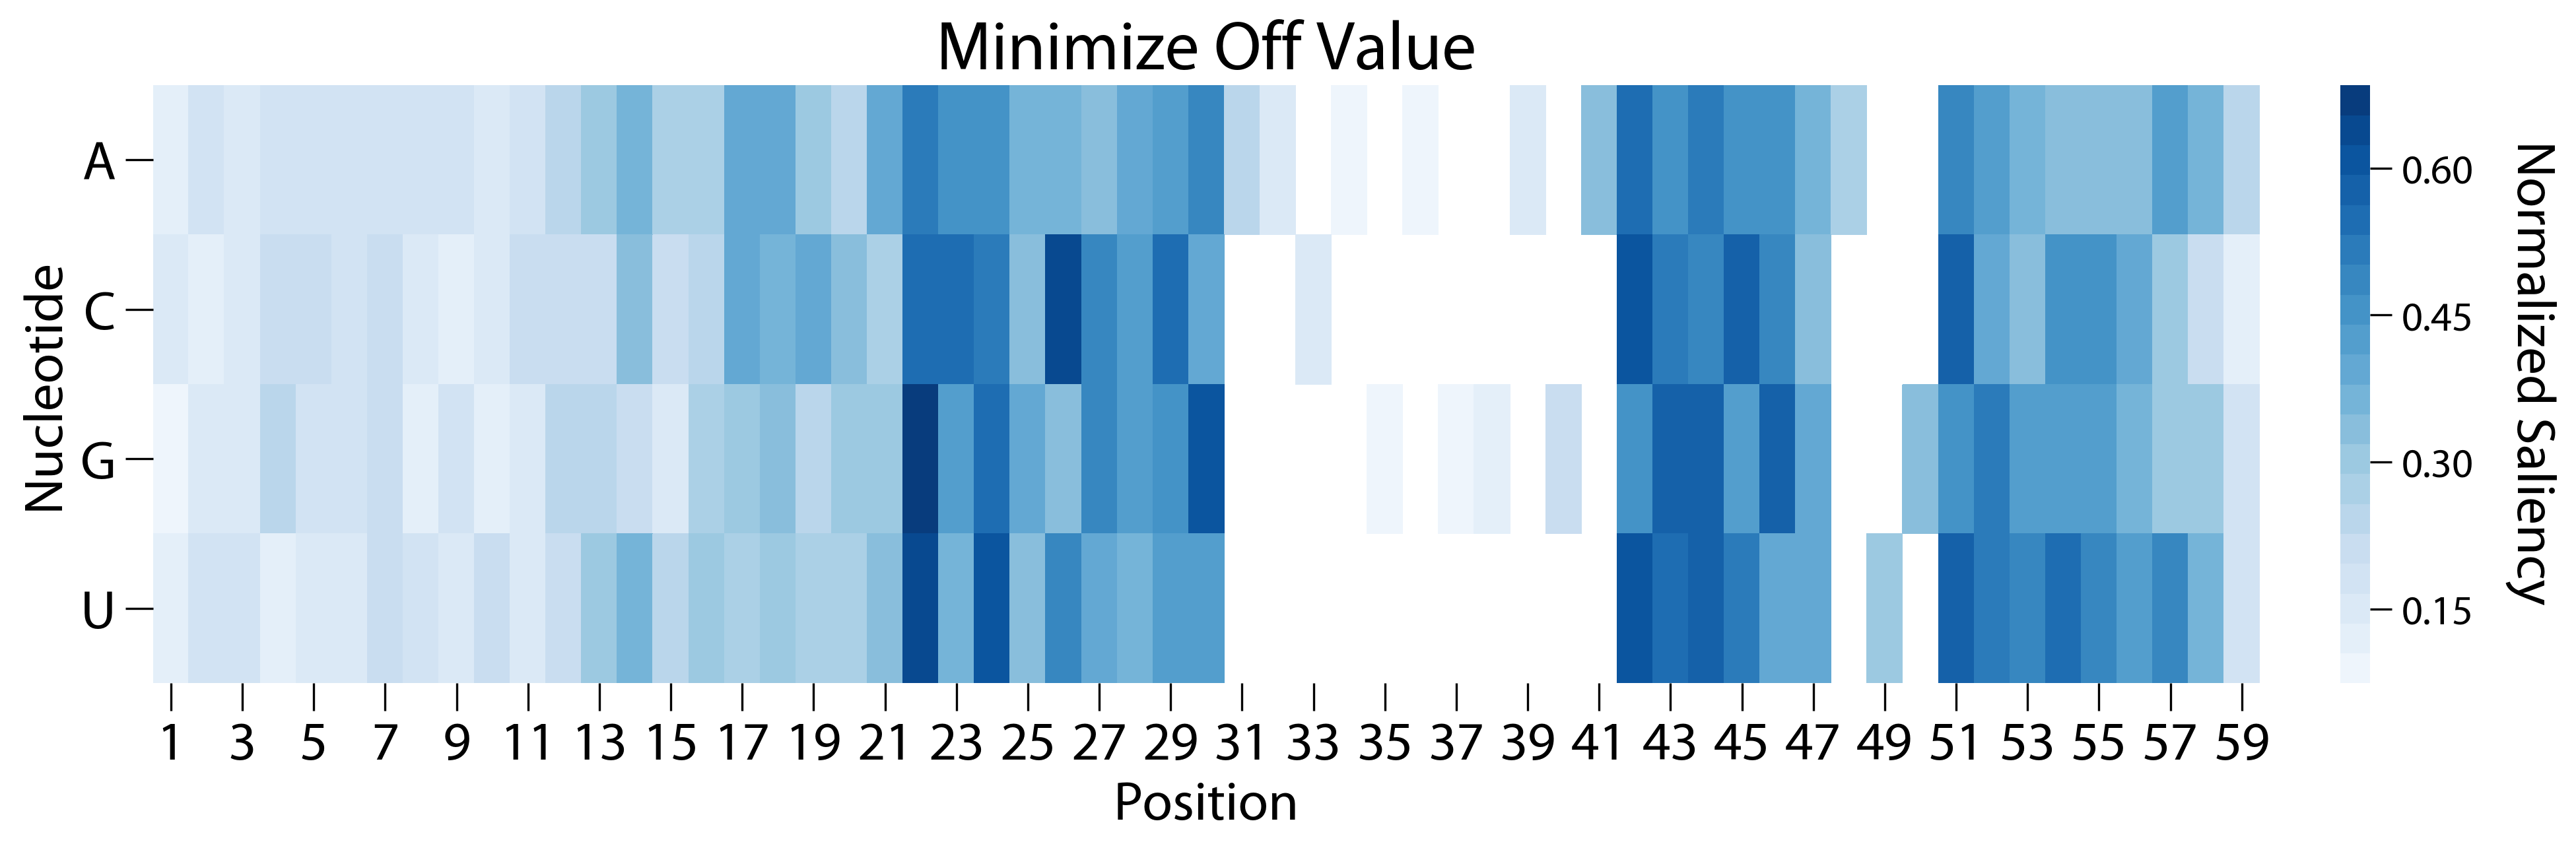

In [59]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)

g = sns.heatmap([grads_over_letters_off[letter]/counts_per_positon_off[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, rotation = 0, **axis_font, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Minimize Off Value', **axis_font, fontsize = 25)
out_dir = '../../illustrator_files/supp/'
plt.savefig(out_dir + 's4d_min_off_bad_saliency.svg', format = 'svg')